Importing needed libraries

In [ ]:
#Tom's Libraries Addition
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve
from sklearn.metrics import confusion_matrix, accuracy_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')


#Tabitha's Libraries Addition
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# **Part 1**

Obtaining the data set

In [ ]:
data = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv',index_col = 0)

Processing the Dataset

In [ ]:
#Goal State
y = data["two_year_recid"]

#Discarding all unused features
used_features = ['sex','age','priors_count','race']


discarded_features = []
for col in data.columns:
  if col not in used_features:
    discarded_features.append(col)

X = data.drop(columns = discarded_features)

#Changing the feature 'sex' from a string into an integer with tag male: 0 and female: 1
X['sex'] = X['sex'].replace({'Male':0, 'Female':1})

#Converting it to Numpy Array
X = X.to_numpy()
y = y.to_numpy()

#Using a 80:20 split for the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 23)

#Getting the number of samples and features
X = np.delete(X, 2, axis = 1)
num_samples, num_features = X.shape

#Getting the race for training and test set. to be used later
X_train_race = X_train
X_test_race = X_test[:,2]
X_train_race_used = X_train[:,2]

#Remodify the data to remove race
X_train = np.delete(X_train, 2, axis = 1)
X_test = np.delete(X_test, 2, axis = 1)

#Converting the data to tensor type
X_train = torch.from_numpy(X_train.astype('float32'))
X_test = torch.from_numpy(X_test.astype('float32'))
y_train = torch.from_numpy(y_train.astype('float32'))
y_test = torch.from_numpy(y_test.astype('float32'))

#Reducing the shape of the goal vector to just a single column
y_train = y_train.view(y_train.shape[0],1)
y_test = y_test.view(y_test.shape[0],1)

Model

Setting up the Logistic Regression Model

In [ ]:
class LogisticRegression(torch.nn.Module):
  def __init__(self,n_input_features):
    super(LogisticRegression,self).__init__()
    self.Linear = torch.nn.Linear(n_input_features, 1)

  def forward(self,x):
    return torch.sigmoid(self.Linear(x))

Running the model

In [ ]:
#Setting up for Accuracy % Losses Graphing
training_accs = []
test_accs = []
training_loss = []
test_losses = []
epochs = []

#Calling the object with num_features (3)
model = LogisticRegression(num_features)

#Defining the loss as log loss or binary cross entropy loss
criterion = nn.BCELoss()

#Defining the optimizer as Stochastic Gradient Descent with a learning rate of 0.01
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

#Training Loop
num_epochs = 100000
for epoch in tqdm(range(num_epochs),desc = 'Training Epoch'):

  #Call the forward pass
  y_pred = model(X_train)
  loss = criterion(y_pred,y_train)

  #Summing up gradient
  loss.backward()

  #Call updates
  optimizer.step()

  #Emptying the gradients
  optimizer.zero_grad()

  if (epoch % 5000) == 0:
    with torch.no_grad():
      print(f'\nepoch: {epoch}')
      epochs.append(epoch)

      #Figuring out Training Losses and Accuracy
      training_acc = y_pred.round().eq(y_train).sum()/float(y_train.shape[0])
      training_accs.append(training_acc)
      training_loss.append(loss.item())
      print(f'Training Loss: {loss.item():.4f} | Training Accuracy: {training_acc}')

      #Figuring out Test Losses and Accuracy
      y_pred_test = model(X_test).round()
      test_acc = y_pred_test.eq(y_test).sum()/float(y_test.shape[0])
      test_accs.append(test_acc)
      test_loss = criterion(y_pred_test,y_test)
      test_losses.append(test_loss.item())
      print(f'Test Loss: {test_loss.item():.4f} | Test Accuracy: {test_acc}')


with torch.no_grad():
  y_pred = model(X_test).round()
  accuracy = y_pred.eq(y_test).sum()/float(y_test.shape[0])
  print('\n')
  print(f'Final Test Accuracy: {accuracy:.4f}')

Training Epoch:   0%|          | 109/100000 [00:00<02:55, 568.32it/s]


epoch: 0
Training Loss: 33.3100 | Training Accuracy: 0.4529544413089752
Test Loss: 55.8559 | Test Accuracy: 0.44144144654273987


Training Epoch:   5%|▌         | 5259/100000 [00:04<01:01, 1529.72it/s]


epoch: 5000
Training Loss: 0.6345 | Training Accuracy: 0.6409634351730347
Test Loss: 35.5509 | Test Accuracy: 0.644490659236908


Training Epoch:  10%|█         | 10223/100000 [00:07<00:59, 1521.09it/s]


epoch: 10000
Training Loss: 0.6313 | Training Accuracy: 0.6449488997459412
Test Loss: 35.2737 | Test Accuracy: 0.6472626328468323


Training Epoch:  15%|█▌        | 15151/100000 [00:11<01:14, 1141.37it/s]


epoch: 15000
Training Loss: 0.6287 | Training Accuracy: 0.6470282673835754
Test Loss: 34.7886 | Test Accuracy: 0.652113676071167


Training Epoch:  20%|██        | 20224/100000 [00:15<00:51, 1547.67it/s]


epoch: 20000
Training Loss: 0.6266 | Training Accuracy: 0.6489343047142029
Test Loss: 34.3035 | Test Accuracy: 0.6569646596908569


Training Epoch:  25%|██▌       | 25260/100000 [00:18<00:50, 1476.68it/s]


epoch: 25000
Training Loss: 0.6248 | Training Accuracy: 0.651360273361206
Test Loss: 33.6105 | Test Accuracy: 0.6638946533203125


Training Epoch:  30%|███       | 30285/100000 [00:21<00:47, 1466.34it/s]


epoch: 30000
Training Loss: 0.6234 | Training Accuracy: 0.6539594531059265
Test Loss: 33.3333 | Test Accuracy: 0.6666666865348816


Training Epoch:  35%|███▌      | 35228/100000 [00:25<00:46, 1387.71it/s]


epoch: 35000
Training Loss: 0.6223 | Training Accuracy: 0.6556922793388367
Test Loss: 33.6105 | Test Accuracy: 0.6638946533203125


Training Epoch:  40%|████      | 40281/100000 [00:29<00:38, 1532.52it/s]


epoch: 40000
Training Loss: 0.6214 | Training Accuracy: 0.6586380004882812
Test Loss: 33.1254 | Test Accuracy: 0.6687456965446472


Training Epoch:  45%|████▌     | 45275/100000 [00:32<00:34, 1568.97it/s]


epoch: 45000
Training Loss: 0.6206 | Training Accuracy: 0.6610639691352844
Test Loss: 32.9868 | Test Accuracy: 0.6701316833496094


Training Epoch:  50%|█████     | 50181/100000 [00:35<00:45, 1105.17it/s]


epoch: 50000
Training Loss: 0.6200 | Training Accuracy: 0.6633166074752808
Test Loss: 32.7789 | Test Accuracy: 0.672210693359375


Training Epoch:  55%|█████▌    | 55164/100000 [00:39<00:29, 1515.37it/s]


epoch: 55000
Training Loss: 0.6195 | Training Accuracy: 0.664702832698822
Test Loss: 32.2938 | Test Accuracy: 0.6770616769790649


Training Epoch:  60%|██████    | 60176/100000 [00:43<00:26, 1517.82it/s]


epoch: 60000
Training Loss: 0.6190 | Training Accuracy: 0.6660890579223633
Test Loss: 32.1552 | Test Accuracy: 0.6784476637840271


Training Epoch:  65%|██████▌   | 65226/100000 [00:46<00:23, 1473.23it/s]


epoch: 65000
Training Loss: 0.6187 | Training Accuracy: 0.6662623286247253
Test Loss: 31.9473 | Test Accuracy: 0.6805266737937927


Training Epoch:  70%|███████   | 70247/100000 [00:50<00:21, 1361.08it/s]


epoch: 70000
Training Loss: 0.6184 | Training Accuracy: 0.671980619430542
Test Loss: 31.1157 | Test Accuracy: 0.6888427138328552


Training Epoch:  75%|███████▌  | 75290/100000 [00:53<00:16, 1520.30it/s]


epoch: 75000
Training Loss: 0.6182 | Training Accuracy: 0.6718072891235352
Test Loss: 31.1157 | Test Accuracy: 0.6888427138328552


Training Epoch:  80%|████████  | 80196/100000 [00:56<00:12, 1541.94it/s]


epoch: 80000
Training Loss: 0.6180 | Training Accuracy: 0.671980619430542
Test Loss: 31.1157 | Test Accuracy: 0.6888427138328552


Training Epoch:  85%|████████▌ | 85137/100000 [01:00<00:11, 1305.48it/s]


epoch: 85000
Training Loss: 0.6178 | Training Accuracy: 0.6742332577705383
Test Loss: 31.3236 | Test Accuracy: 0.6867637038230896


Training Epoch:  90%|█████████ | 90198/100000 [01:04<00:06, 1425.26it/s]


epoch: 90000
Training Loss: 0.6177 | Training Accuracy: 0.6744065284729004
Test Loss: 31.3236 | Test Accuracy: 0.6867637038230896


Training Epoch:  95%|█████████▌| 95269/100000 [01:07<00:03, 1478.99it/s]


epoch: 95000
Training Loss: 0.6176 | Training Accuracy: 0.6744065284729004
Test Loss: 31.3929 | Test Accuracy: 0.6860706806182861


Training Epoch: 100%|██████████| 100000/100000 [01:10<00:00, 1413.67it/s]



Final Test Accuracy: 0.6861


Graphing Accuracy

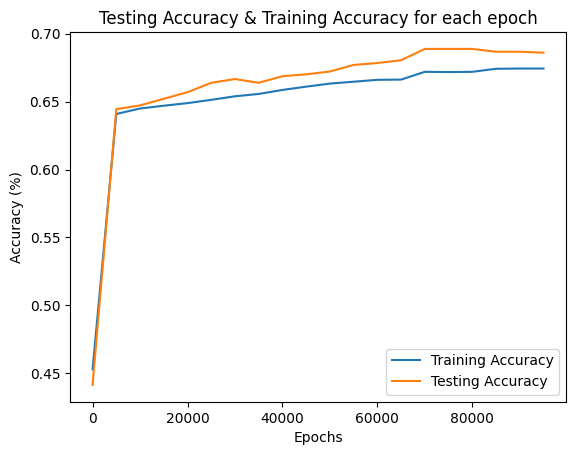

In [ ]:
plt.plot(epochs,training_accs, label = "Training Accuracy")
plt.plot(epochs,test_accs, label = "Testing Accuracy")
plt.title("Testing Accuracy & Training Accuracy for each epoch")
plt.ylabel("Accuracy (%)")
plt.xlabel("Epochs")
plt.legend(loc = "lower right")
plt.show()

Graphing Losses

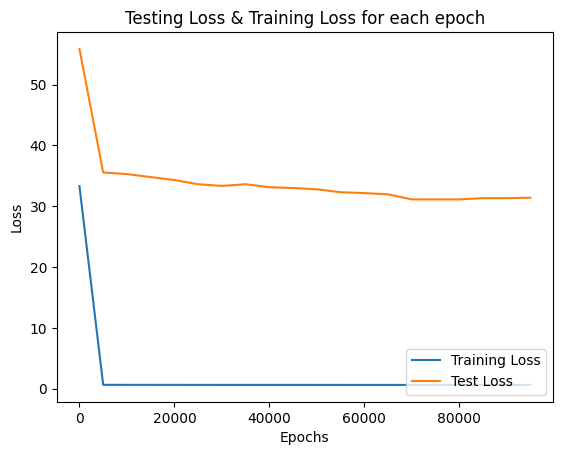

In [ ]:
plt.plot(epochs, training_loss, label = "Training Loss")
plt.plot(epochs, test_losses, label = "Test Loss")
plt.title("Testing Loss & Training Loss for each epoch")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc = "lower right")
plt.show()

# **Checking for False Positive Parity**

Transforming the prediction and target vector to numpy form and transposing them

In [ ]:
y_pred = y_pred.numpy()
y_test = y_test.numpy()
y_test = y_test.transpose()
y_pred = y_pred.transpose()

Determining the False Postiive Ratio for Caucasian and African-American dataset

In [ ]:
#Calculating caucasian FPR
white_true_neg = ((y_test == 0) & (y_pred == 0) & (X_test_race == 'Caucasian')).sum()
white_false_positive = ((y_test == 0) & (y_pred == 1) & (X_test_race == 'Caucasian')).sum()
white_fpr = white_false_positive / (white_true_neg + white_false_positive)
print("False Positve Ratio for Caucasian demographic is " + str(white_fpr))

black_true_neg = ((y_test == 0) & (y_pred == 0) & (X_test_race == 'African-American')).sum()
black_false_positive = ((y_test == 0) & (y_pred == 1) & (X_test_race == 'African-American')).sum()
black_fpr = black_false_positive / (black_true_neg + black_false_positive)
print("False Positive Ratio for African-American is " + str(black_fpr))

print('Difference between African-American fpr and Caucasian fpr is ' + str(abs(black_fpr - white_fpr)))

var = np.sqrt((white_fpr * (1 - white_fpr) / ((X_test_race == 'Caucasian').sum())) + ((black_fpr * (1 - black_fpr))/ (X_test_race == 'African-American').sum()))
error = np.sqrt(8) * var

if abs(black_fpr - white_fpr) > error:
  print("Model does not satisfy False Positive Parity")
else:
  print("Model does satisfy False Positive Parity")

False Positve Ratio for Caucasian demographic is 0.1498371335504886
False Positive Ratio for African-American is 0.28610354223433243
Difference between African-American fpr and Caucasian fpr is 0.13626640868384382
Model does not satisfy False Positive Parity


Note that this False Positive Parity Check is done using the test set, while the later False Positive Parity Check with a variable threshold is done using the training set instead since the Calibration is done using the training set as well.

# **Checking for Calibration**

Setting up African American only training set and Caucasian only training set and their respective target

Converting the target for the training set to numpy form and transposing them

In [ ]:
y_train = y_train.numpy()
y_train = y_train.transpose()

Dividing the dataset into caucasian and african american

In [ ]:
X_train_white = []
X_train_black = []
y_train_white = []
y_train_black = []

#Creating training set for African American and Caucasian
for n,i in enumerate(X_train_race):
  temp = []
  temp2 = []
  if i[2] == 'Caucasian':
    temp.append(i[0])
    temp.append(i[1])
    temp.append(i[3])
    X_train_white.append(temp)
    y_train_white.append(y_train[0][n])
  if i[2] == 'African-American':
    temp2.append(i[0])
    temp2.append(i[1])
    temp2.append(i[3])
    X_train_black.append(temp2)
    y_train_black.append(y_train[0][n])

#Choosing only 10 percent of each race. This should be random, but it already is since the training set was randomly selected
X_train_black = X_train_black[:int(len(X_train_black) * 0.1)]
y_train_black = y_train_black[:int(len(y_train_black) * 0.1)]
X_train_white = X_train_white[:int(len(X_train_white) * 0.1)]
y_train_white = y_train_white[:int(len(y_train_white) * 0.1)]

#Converting the training set tobe tensor format
X_train_white = np.asarray(X_train_white)
X_train_black = np.asarray(X_train_black)
y_train_white = np.asarray(y_train_white)
y_train_black = np.asarray(y_train_black)
X_train_white = torch.from_numpy(X_train_white.astype('float32'))
X_train_black = torch.from_numpy(X_train_black.astype('float32'))
y_train_white = torch.from_numpy(y_train_white.astype('float32'))
y_train_black = torch.from_numpy(y_train_black.astype('float32'))

Calculating the calibration score

In [ ]:
y_pred_white = model(X_train_white)
y_pred_black = model(X_train_black)

#Calculating confusion matrix
with torch.no_grad():
  white_matrix = confusion_matrix(y_train_white, torch.round(y_pred_white))
  black_matrix = confusion_matrix(y_train_black, torch.round(y_pred_black))

#Calculate Calibration Score
score_white_1 = white_matrix[1][1] / (white_matrix[1][1] + white_matrix[0][1])
score_black_1 = black_matrix[1][1] / (black_matrix[1][1] + black_matrix[0][1])

score_white_0 = white_matrix[0][0] / (white_matrix[0][0] + white_matrix[1][0])
score_black_0 = black_matrix[0][0] / (black_matrix[0][0] + black_matrix[1][0])

#Calculate Variances and Errors
var_1 = ((score_white_1 * (1 - score_white_1)) / X_train_white.shape[0]) + ((score_black_1 * (1 - score_black_1)) / X_train_black.shape[0])
error_1 = 2 * np.sqrt(2) * np.sqrt(var_1)
var_0 = ((score_white_0 * (1 - score_white_0)) / X_train_white.shape[0]) + ((score_black_0 * (1 - score_black_0)) / X_train_black.shape[0])
error_0 = 2 * np.sqrt(2) * np.sqrt(var_0)

#Determining if the model is calibrated
if (abs(score_white_1 - score_black_1) < error_1) and (abs(score_white_0 - score_black_0) < error_0):
  print("Model is properly Calibrated")
else:
  print("Model is not properly Calibrated")

Model is properly Calibrated


# **Adjusting the Threshold Inorder to Compare Calibration and False Positive Parity**

Start first by writing the functions needed inorder to calculate False Positive Rate and Calibration

Function for Calibration


In [ ]:
def determine_calibration(white_threshold, black_threshold, y_pred_white, y_pred_black):

  white_threshold = round(white_threshold,1)
  black_threshold = round(black_threshold,1)

  #Determining the prediction outcome with the given threshold
  y_pred_black_actual = []
  y_pred_white_actual = []
  for i in y_pred_white[0]:
    if i > white_threshold:
      y_pred_white_actual.append(1)
    else:
      y_pred_white_actual.append(0)
  
  for i in y_pred_black[0]:
    if i > black_threshold:
      y_pred_black_actual.append(1)
    else:
      y_pred_black_actual.append(0)

  #Converting the data back to tensor
  y_pred_black_actual = np.asarray(y_pred_black_actual)
  y_pred_white_actual = np.asarray(y_pred_white_actual)
  y_pred_black_actual = torch.from_numpy(y_pred_black_actual.astype('float32'))
  y_pred_white_actual = torch.from_numpy(y_pred_white_actual.astype('float32'))

  #Calculate the confusion Matrixes
  with torch.no_grad():
    white_matrix = confusion_matrix(y_train_white, torch.round(y_pred_white_actual - white_threshold + 0.5))
    black_matrix = confusion_matrix(y_train_black, torch.round(y_pred_black_actual  - black_threshold + 0.5))

  #Calculate Calibration Score
  score_white_1 = round(white_matrix[1][1] / (white_matrix[1][1] + white_matrix[0][1]),1)
  score_black_1 = round(black_matrix[1][1] / (black_matrix[1][1] + black_matrix[0][1]),1)

  score_white_0 = round(white_matrix[0][0] / (white_matrix[0][0] + white_matrix[1][0]),1)
  score_black_0 = round(black_matrix[0][0] / (black_matrix[0][0] + black_matrix[1][0]),1)

  #Calculate Variances and Errors
  var_1 = ((score_white_1 * (1 - score_white_1)) / X_train_white.shape[0]) + ((score_black_1 * (1 - score_black_1)) / X_train_black.shape[0])
  error_1 = 2 * np.sqrt(2) * np.sqrt(var_1)
  var_0 = ((score_white_0 * (1 - score_white_0)) / X_train_white.shape[0]) + ((score_black_0 * (1 - score_black_0)) / X_train_black.shape[0])
  error_0 = 2 * np.sqrt(2) * np.sqrt(var_0)

  #Determining if the model is calibrated
  if (abs(score_white_1 - score_black_1) < error_1) and (abs(score_white_0 - score_black_0) < error_0):
    print("Model is properly Calibrated\n")
    return True
  else:
    print("Model is not properly Calibrated\n")
    return False

Function for False Positive Parity

In [ ]:
def fpr_calculation(white_threshold, black_threshold, y_pred):

  white_threshold = round(white_threshold,1)
  black_threshold = round(black_threshold,1)

  y_pred_black = []
  y_pred_white = []
  for i in y_pred[0]:
    if i > white_threshold:
      y_pred_white.append(1)
    else:
      y_pred_white.append(0)
  
  for i in y_pred[0]:
    if i > black_threshold:
      y_pred_black.append(1)
    else:
      y_pred_black.append(0)

  y_pred_black = np.asarray(y_pred_black)
  y_pred_white = np.asarray(y_pred_white)

  white_true_neg = ((y_train == 0) & (y_pred_white == 0) & (X_train_race_used == 'Caucasian')).sum()
  white_false_positive = ((y_train == 0) & (y_pred_white == 1) & (X_train_race_used == 'Caucasian')).sum()
  white_fpr = white_false_positive / (white_true_neg + white_false_positive)
  #print("False Positve Ratio for Caucasian demographic is " + str(white_fpr))

  black_true_neg = ((y_train == 0) & (y_pred_black == 0) & (X_train_race_used == 'African-American')).sum()
  black_false_positive = ((y_train == 0) & (y_pred_black == 1) & (X_train_race_used == 'African-American')).sum()
  black_fpr = black_false_positive / (black_true_neg + black_false_positive)
  #print("False Positive Ratio for African-American is " + str(black_fpr))

  var = np.sqrt((white_fpr * (1 - white_fpr) / ((X_train_race_used == 'Caucasian').sum())) + ((black_fpr * (1 - black_fpr))/ (X_train_race_used == 'African-American').sum()))

  error = np.sqrt(8) * var

  if abs(black_fpr - white_fpr) > error:
    print("Model does not satisfy False Positive Parity")
    return False
  else:
    print("Model does satisfy False Positive Parity")
    return True

Looping through different thresholds for both African-American and Caucasian demographic starting at 0.1 ending at 1 for both

In [ ]:
y_pred_white = model(X_train_white)
y_pred_white = y_pred_white.detach().numpy()
y_pred_white = y_pred_white.transpose()

y_pred_black = model(X_train_black)
y_pred_black = y_pred_black.detach().numpy()
y_pred_black = y_pred_black.transpose()

y_pred = model(X_train)
y_pred = y_pred.detach().numpy()
y_pred = y_pred.transpose()

ans = []

bt = 0.1
wt = 0.1
while bt < 1:
  wt = 0.1
  while wt < 1:
    print("With African-American Threshold " + str(round(bt,1)) + " and Caucasian Threshold " + str(round(wt,1)))
    parity = fpr_calculation(wt,bt,y_pred)
    cali = determine_calibration(wt, bt, y_pred_white, y_pred_black)

    if parity == True and cali == False:
      ans.append((round(wt,1),round(bt,1)))
    wt += 0.1
  bt += 0.1

print(ans)

With African-American Threshold 0.1 and Caucasian Threshold 0.1
Model does satisfy False Positive Parity
Model is not properly Calibrated

With African-American Threshold 0.1 and Caucasian Threshold 0.2
Model does not satisfy False Positive Parity
Model is not properly Calibrated

With African-American Threshold 0.1 and Caucasian Threshold 0.3
Model does not satisfy False Positive Parity
Model is not properly Calibrated

With African-American Threshold 0.1 and Caucasian Threshold 0.4
Model does not satisfy False Positive Parity
Model is not properly Calibrated

With African-American Threshold 0.1 and Caucasian Threshold 0.5
Model does not satisfy False Positive Parity
Model is not properly Calibrated

With African-American Threshold 0.1 and Caucasian Threshold 0.6
Model does not satisfy False Positive Parity
Model is not properly Calibrated

With African-American Threshold 0.1 and Caucasian Threshold 0.7
Model does not satisfy False Positive Parity
Model is not properly Calibrated

Wit

The two thresholds that satisfies false positive parity (given as (threshold for caucasian, threshold for african-american)) are (0.1,0.1), (0.7,0.8), (0.8,0.9), (0.9,1.0).

Note that (1.0,1.0) will be excluded since this data means every data point will result in the same outcome

# **Part 2** (Option 1)

**Obtaining validation set:**

In [ ]:
y = data["two_year_recid"]

used_features = ['sex','age','priors_count','race']


discarded_features = []
for col in data.columns:
  if col not in used_features:
    discarded_features.append(col)

X = data.drop(columns = discarded_features)

X['sex'] = X['sex'].replace({'Male':0, 'Female':1})

X = X.to_numpy()
y = y.to_numpy()

# 80% training, 20% validation and testing
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=15)

# temp: 50% validation, 50% testing
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=15)

X_train_race = X_train
X_val_race = X_val[:, 2]
X_test_race = X_test[:, 2]

X_train = np.delete(X_train, 2, axis = 1)
X_val = np.delete(X_val, 2, axis = 1)
X_test = np.delete(X_test, 2, axis = 1)

X_train = torch.from_numpy(X_train.astype('float32'))
X_val = torch.from_numpy(X_val.astype('float32'))
X_test = torch.from_numpy(X_test.astype('float32'))
y_train = torch.from_numpy(y_train.astype('float32'))
y_val = torch.from_numpy(y_val.astype('float32'))
y_test = torch.from_numpy(y_test.astype('float32'))

y_train = y_train.view(y_train.shape[0], 1)
y_val = y_val.view(y_val.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

**Traning and improving on your initial results:**

Strategies from the Deep Learning Tuning Playbook:


1.  Choosing the optimizer

> *   Chose the Adam optimizer recommended in the playbook and tuned one of it's hyperparameters: the learning rate.
> > * For <10 trials, only tuned the learning rate
> > > *  Set the other hyperparameters: Beta 1, 2, and epsilon as their default values.


2.  Choosing the initial configuration

> *  Specified (1) model configuration, (2) optimizer hyperparameters, and (3) the number of training steps 
> > * Tuned the number of hidden layers, the learning rate of the optimizer, and the number of epochs, accordingly.
> > * Followed the guide of "find(ing) a simple, relatively fast, relatively low-resource-consumption configuration that obtains a "reasonable" result.
> > > * Started with a constant learning rate = 1e-3 and 50 epochs and tuned accordingly from there
> > * Implemented learning rate scheduling. 

3. Exploration vs exploitation

> * I identified the learning rate of the optimizer and the fairness hyperparameter, beta as the hyperparameters the losses are most sensitive to. Thus, focused on tuning them as the playbook suggested. 


I also implemented early stopping to increase the efficiency of the testing.


**Strategies that I did not implement:**

1. Choosing the batch size:
> * I did not choose a specific batch size and just set it as 1 (i.e. stochastic gradient descent)
> > * Given the relatively simple model architecture + small dataset, I believed that stochastic gradient descent was a sufficient choice

2. Optimizing the input pipeline:
> * Since the dataset was relatively small and no complex preprocessing steps were involved, I concluded that the default PyTorch dataloader was sufficient, thus not necessarily optimizing the input pipeline. 


In [ ]:
class FairAdversarialNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(FairAdversarialNetwork, self).__init__()
        self.g = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU() # activation
        )
        self.f_ = nn.Linear(hidden_size, 1) # f_ = f'
        self.phi_ = nn.Linear(hidden_size, 1) # phi_ = φ'

    def forward(self, x):
        x_ = self.g(x) # x_ = x'
        y_hat = self.f_(x_) 
        s_hat = self.phi_(x_) 
        return y_hat, s_hat

input_size = 3  # num of input features
hidden_size = 128 # num of hidden units in single hidden layer of FAD: HYPERPARAMETER
model = FairAdversarialNetwork(input_size, hidden_size)

# cost functions <-- our choice: Binary Cross Entropy Loss
err_y = nn.BCELoss()
err_s = nn.BCELoss()

# optimizers
opt_g = optim.Adam(model.g.parameters(), lr=1e-2) # learning rate: HYPERPARAMETER
opt_f_ = optim.Adam(model.f_.parameters(), lr=1e-2)
opt_phi_ = optim.Adam(model.phi_.parameters(), lr=1e-2)

scheduler_g = ReduceLROnPlateau(opt_g, mode='min', factor=0.1, patience=3, verbose=True)
scheduler_f_ = ReduceLROnPlateau(opt_f_, mode='min', factor=0.1, patience=3, verbose=True)
scheduler_phi_ = ReduceLROnPlateau(opt_phi_, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 50 # HYPERPARAMETER
beta = 0.5  # fairness HYPERPARAMETER

patience = 5 # early stopping patience HYPERPARAMETER
best_val_loss = float('inf')
bad_epochs = 0

for epoch in range(num_epochs):
    for i, (x, y, s) in enumerate(zip(X_train, y_train, X_train[:, 0])):
        x = x.float()
        y = y.float()
        s = s.float().unsqueeze(-1)  

        y_hat, s_hat = model(x)

        # to make them within range 0 to 1
        y_hat = torch.sigmoid(y_hat)
        s_hat = torch.sigmoid(s_hat)

        loss_y = err_y(y_hat, y)
        loss_s = err_s(s_hat, s)

        opt_g.zero_grad()
        opt_f_.zero_grad()

        loss_y.backward(retain_graph=True)
        opt_g.step()
        opt_f_.step()

        opt_g.zero_grad()
        opt_phi_.zero_grad()

        loss_s.backward()
        for v in model.g.parameters():
            v.grad.data = -beta * v.grad.data 

        opt_g.step()
        opt_phi_.step()
        
    with torch.no_grad():
        y_val_hat, _ = model(X_val)
        y_val_hat = torch.sigmoid(y_val_hat)
        val_loss = err_y(y_val_hat, y_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss(y): {loss_y.item()}, Loss(s): {loss_s.item()},  Validation Loss(y): {val_loss.item()}") 

    scheduler_g.step(val_loss)
    scheduler_f_.step(val_loss)
    scheduler_phi_.step(val_loss)

    # early stopping:
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      bad_epochs = 0
    else:
      bad_epochs += 1
      if bad_epochs >= patience:
        print("Early Stopping")
        break

y_test_hat, _ = model(X_test)
y_test_hat = torch.sigmoid(y_test_hat)

y_test_pred = (y_test_hat > 0.5).float()

accuracy = torch.mean((y_test_pred == y_test).float()).item()

print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50, Loss(y): 0.5231202244758606, Loss(s): 0.08469840884208679,  Validation Loss(y): 0.6392517685890198
Epoch 2/50, Loss(y): 0.4813934564590454, Loss(s): 0.1541779339313507,  Validation Loss(y): 0.6273133754730225
Epoch 3/50, Loss(y): 0.5757675170898438, Loss(s): 0.17742709815502167,  Validation Loss(y): 0.6229879856109619
Epoch 4/50, Loss(y): 0.5833526253700256, Loss(s): 0.17776566743850708,  Validation Loss(y): 0.6233306527137756
Epoch 5/50, Loss(y): 0.5864089131355286, Loss(s): 0.17772379517555237,  Validation Loss(y): 0.623771607875824
Epoch 6/50, Loss(y): 0.5947917103767395, Loss(s): 0.1788390576839447,  Validation Loss(y): 0.6247473955154419
Epoch 7/50, Loss(y): 0.5867666602134705, Loss(s): 0.1765347719192505,  Validation Loss(y): 0.624011754989624
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 00007: reducing learning rate of group 0 to 1.0000e-03.
Epoch 8/50, Loss(y): 0.6689655780792236, L

**Mode Collapse:**

In [ ]:
class OutcomePredictor(nn.Module):
    def __init__(self, hidden_size):
        super(OutcomePredictor, self).__init__()
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x_):
        x = self.fc1(x_)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.sigmoid(x)

# Get the x_ values for the train, validation, and test sets
X_train_x_ = model.g(X_train)
X_val_x_ = model.g(X_val)
X_test_x_ = model.g(X_test)

# Create tensors for the x_ values
X_train_x_ = torch.from_numpy(X_train_x_.detach().numpy().astype('float32'))
X_val_x_ = torch.from_numpy(X_val_x_.detach().numpy().astype('float32'))
X_test_x_ = torch.from_numpy(X_test_x_.detach().numpy().astype('float32'))

# Train OutcomePredictor using x'(= x_) activations
outcome_predictor = OutcomePredictor(hidden_size)
outcome_predictor_optimizer = optim.Adam(outcome_predictor.parameters(), lr=0.1)
outcome_predictor_loss = nn.BCELoss()

scheduler_outcome_predictor = ReduceLROnPlateau(outcome_predictor_optimizer, mode='min', factor=0.1, patience=3, verbose=True)

num_epochs = 50
patience = 5
best_val_loss = float('inf')
bad_epochs = 0

for epoch in range(num_epochs):
    for x_, y in zip(X_train_x_, y_train):
        x_ = x_.float()
        y = y.float()

        y_hat = outcome_predictor(x_)

        loss = outcome_predictor_loss(y_hat, y)

        outcome_predictor_optimizer.zero_grad()
        loss.backward()
        outcome_predictor_optimizer.step()

    with torch.no_grad():
        y_val_hat = outcome_predictor(X_val_x_)
        val_loss = outcome_predictor_loss(y_val_hat, y_val)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    scheduler_outcome_predictor.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        bad_epochs = 0
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print("Early Stopping")
            break

y_hat_outcome_predictor = (outcome_predictor(X_test_x_) > 0.5).float()

accuracy = (y_hat_outcome_predictor == y_test).sum().item() / y_test.shape[0]

print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50, Loss: 0.5872561931610107, Validation Loss: 0.689481258392334
Epoch 2/50, Loss: 0.5872560143470764, Validation Loss: 0.689481258392334
Epoch 3/50, Loss: 0.5872560143470764, Validation Loss: 0.6894813776016235
Epoch 4/50, Loss: 0.5872560143470764, Validation Loss: 0.6894813776016235
Epoch 5/50, Loss: 0.5872560143470764, Validation Loss: 0.6894813776016235
Epoch 00005: reducing learning rate of group 0 to 1.0000e-02.
Epoch 6/50, Loss: 0.6293752193450928, Validation Loss: 0.6893521547317505
Epoch 7/50, Loss: 0.6293757557868958, Validation Loss: 0.6893522143363953
Epoch 8/50, Loss: 0.6293757557868958, Validation Loss: 0.6893522143363953
Epoch 9/50, Loss: 0.6293757557868958, Validation Loss: 0.6893522143363953
Epoch 10/50, Loss: 0.6293757557868958, Validation Loss: 0.6893522143363953
Epoch 00010: reducing learning rate of group 0 to 1.0000e-03.
Epoch 11/50, Loss: 0.6070735454559326, Validation Loss: 0.6890779137611389
Epoch 12/50, Loss: 0.6058841943740845, Validation Loss: 0.6890

Random baseline accuracy:

In [ ]:
random_predictions = np.random.randint(0, 2, y_test.shape[0])
random_accuracy = (random_predictions == y_test.numpy().flatten()).mean()

print(f"Random baseline accuracy: {random_accuracy * 100:.2f}%")

Random baseline accuracy: 54.16%


You can see here that the accuracy is about the same as the random baseline accuracy (for this trial, the OutputPredictor accuracy was 53.19% and the random baseline accuracy was 54.16% unlike the main model with an accuracy of 68.01%), thus it is impossible to train a network to predict the outcome of interest from it.

**Improving Performance:**

In [ ]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.neg() * ctx.alpha
        return grad_input, None

best_val_loss = float('inf')
bad_epochs = 0

# Training loop with gradient reversal
for epoch in range(num_epochs):
    for i, (x, y, s) in enumerate(zip(X_train, y_train, X_train[:, 0])):
        x = x.float()
        y = y.float()
        s = s.float().unsqueeze(-1)

        y_hat, s_hat = model(x)

        y_hat = torch.sigmoid(y_hat)
        s_hat = torch.sigmoid(s_hat)

        loss_y = err_y(y_hat, y)
        loss_s = err_s(s_hat, s)

        opt_g.zero_grad()
        opt_f_.zero_grad()

        loss_y.backward(retain_graph=True)
        opt_g.step()
        opt_f_.step()

        opt_g.zero_grad()
        opt_phi_.zero_grad()

        # gradient reversal
        x_ = model.g(x).detach()
        x_.requires_grad_(True)
        s_hat = model.phi_(GradientReversalFunction.apply(x_, beta))
        s_hat = torch.sigmoid(s_hat)

        loss_s = err_s(s_hat, s)
        loss_s.backward()
        opt_phi_.step()

    with torch.no_grad():
        y_val_hat, _ = model(X_val)
        y_val_hat = torch.sigmoid(y_val_hat)
        val_loss = err_y(y_val_hat, y_val)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss(y): {loss_y.item()}, Loss(s): {loss_s.item()},  Validation Loss(y): {val_loss.item()}") 

    scheduler_g.step(val_loss)
    scheduler_f_.step(val_loss)
    scheduler_phi_.step(val_loss)

    # early stopping:
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      bad_epochs = 0
    else:
      bad_epochs += 1
      if bad_epochs >= patience:
        print("Early Stopping")
        break

y_test_hat, _ = model(X_test)
y_test_hat = torch.sigmoid(y_test_hat)

y_test_pred = (y_test_hat > 0.5).float()

accuracy = torch.mean((y_test_pred == y_test).float()).item()

print(f"Accuracy: {accuracy * 100:.2f}%")

Epoch 1/50, Loss(y): 0.6412372589111328, Loss(s): 0.2139877825975418,  Validation Loss(y): 0.6093387603759766
Epoch 2/50, Loss(y): 0.6486008167266846, Loss(s): 0.21354207396507263,  Validation Loss(y): 0.6092073917388916
Epoch 3/50, Loss(y): 0.6529906988143921, Loss(s): 0.21232746541500092,  Validation Loss(y): 0.6091622114181519
Epoch 4/50, Loss(y): 0.6589343547821045, Loss(s): 0.21040812134742737,  Validation Loss(y): 0.6091252565383911
Epoch 5/50, Loss(y): 0.6618297100067139, Loss(s): 0.20845931768417358,  Validation Loss(y): 0.6091791987419128
Epoch 6/50, Loss(y): 0.6641389727592468, Loss(s): 0.20642583072185516,  Validation Loss(y): 0.6092584133148193
Epoch 7/50, Loss(y): 0.6672517657279968, Loss(s): 0.20419777929782867,  Validation Loss(y): 0.6093438267707825
Epoch 8/50, Loss(y): 0.6697092652320862, Loss(s): 0.2020144909620285,  Validation Loss(y): 0.6094558238983154
Epoch 00058: reducing learning rate of group 0 to 1.0000e-04.
Epoch 00058: reducing learning rate of group 0 to 1.

# **Part 3**

Ethical Reflection

a. In the context of recidivism prediction for COMPAS, present an argument in favour of aiming for demographic parity.

  Demographic Parity can be defined as a concept that aims to ensure that the predicted outcomes or decisions of the model to be fair and unbias. This can be achieved by having the same distribution of positives for every demographic, so that the model can learn to predict the same outcome distribution across different groups. Regardless of factors such as race, and gender. This seems fair in the context of the recidivism prediction for COMPAS. Demographic parity for recidivism prediction for COMPAS would mean having the same proportion of positive classifications for every race demographic, which is fair since it eliminates biases. The biggest concern is that model can replicated human biases in race and gender in selecting recidivism, and therefore having demographic parity would help in eliminating that.

b. In the context of recidivism prediction for COMPAS, present an argument in favour of aiming for false-positive parity.

False-positve parity can be defined as a concept that aims to ensure that the rate of false positive predictions is equal across different demographic groups.In the the context of the recividism prediction for COMPAS, ensuring false-positive parity accross different demographic is fair since it will eliminate racial or gender bias. If false-positive parity is not achieved in this case, there could be racial bias such as more black prisoners are being wrongly classified than white prisoners, or more male are being misclassified than female. As a result, ensuring false positive parity across the demographics will help towards eliminating the racial and gender biases.

c. In the context of recidivism prediction for COMPAS, present an argument in favour of aiming for calibration.

Calibration in the context of a machine learning model can be explained as when the machine learning model can output a probability that is accurate to the real world. In another word, the model is an accurate reflection of the events it predicts. In the context of recidivism for COMPAS, there is a strong case for aiming for calibration. The goal of the COMPAS model is to output a probability of reoffending for a person that is accurate based on real world probability of reoffending. For example, if a person has a 65 percent chance of reoffending, the model should be able to predict that. Essentially, a well calibrated model will give an accurate prediction of a prisoner reoffending. This is crucial when looking at different demographics. In a model that is not well calibrated, a group of prisoners with one race demographic that is most likely to offend can be predicted as less likely to offend, which is incorrect, and vice versa.


d. In the context of recidivism prediction for COMPAS, consider Sharad Goel’s concepts of aggregate social welfare, and aggregate social welfare as computed for each demographic separately. Make one argument in favour of using those concepts. Make two arguments against those thinking that those concepts should guide the design of systems; at least one of those arguments should be specific to the aggregate social welfare as computed for each demograhic separately.


In the context of recidivism prediction for COMPAS, one argument can be made in favour of Sharad Goel's concepts of aggregate social welfare and aggregate social welfare as computed for each demographic separetely is that it allows for a more nuanced way of understanding how many different decisions and policies may impact different groups within a certain population. As a result, by calculating social welfare measures for each demographic individually and separately, it becomes easier to spot potential disparities or potential biases in the system, and further work can be done to address these biases.

There are two arguments that can also be made against using these concepts to guide the design of systems. The concept of aggregate social welfare oversimplifies the complex nature of social systems. As a result, it may not always be accurate to the interests of all individuals within a population. For example, a policy or decision that maximizes aggregate social welfare may still disproportionaltely harm certain individuals or communities. Secondly, The concept of aggregate social welfare as computed for each demographic separately may lead to the creation of silos that will treat differing groups as isolated from each other. As a result, harmful stereotypes can occur due to the isolation and social division will be encouraged. Furthermore, intersectional identities are not taken into account, where individuals may belong to multiple demographic at the same time, which significantly complicates the analysis.



e. There are many contexts in which prediction systems are currently being used. Examples include credit scores; university admissions; insurance rate offers; early-warning systems for deterioriating patients in hospital. Pick one field (not necessarily one of the ones I listed) where you think the ethical considerations are different from the ethical considerations for COMPAS. Argue that the ethical considerations for the two cases are different, and connect your argument to observational and causal measures of fairness that we discussed in class.

One field where ethical considerations of predictive algorithms are used to identify patients who are at high risk of developing certain medical conditions or illnesses. In this context, the ethical considerations differ from those for COMPAS. For example, a false negative or false positive prediction can result in much more devasting outcome than the case for COMPAS. A false negative prediction that a patient is not at risk of developing a serious illness could result in a delay of much needed treatment and could lead to a life-threatening condition if delayed for too long. On the flip side, false positive prediction could result in unnecessary medical help, which could be expensive, and could potentially threaten the patient's health. For the case of COMPAS, false negative will remove a prisoner's rights away even though they have earned it but will not threaten anyone's health. As a result, it is important to consider both observational and causal measures of fairness when developing and using predictive algorithms in healthcare. Fairness is one of the key priorities and observational measures of fairness can be used to achieve that; measures include ensuring that the data used to train the algorithm is representative of the entire population, and is well calibrated to not contain biases such as race, or gender. Additionally, causal measures of fairness can be used to ensure that the algorithm is not only accurate but also achieves desirable outcomes, such as reducing healthcare disparities or improving health outcomes for underrepresented groups.
